In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
file_path = 'drive/My Drive/Colab Notebooks/Antivirus_Dataset_Jar.csv'
df = pd.read_csv(file_path, low_memory=False, sep=";")

num_columns_len = len(df.columns)
print(f"Number of columns: {num_columns_len}")

num_rows_len = len(df)
print(f"Number of rows: {num_rows_len}")

FileNotFoundError: [Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Antivirus_Dataset_Jar.csv'

In [ ]:
class_col = [col for col in df.columns if 'class (' in col.lower()][0]
class_col

'class (0:benign, 1:malware)'

In [ ]:
x = df.drop(columns=['files', class_col])
y = df['files']
y_binary = y.apply(lambda x: 1 if '/malwares/' in x else (0 if '/benigns/' in x else None))


In [ ]:
descriptive_stats = y_binary.describe()
print(descriptive_stats)

count    1996.000000
mean        0.500000
std         0.500125
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: files, dtype: float64


In [ ]:
# Set a random seed
random_seed = 72
np.random.seed(random_seed)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, random_state=random_seed)

# Pipeline for imputation and scaling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Fit and transform the training data, and transform the test data
x_train_scaled = pipeline.fit_transform(x_train)
x_test_scaled = pipeline.transform(x_test)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 6826']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 6826']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [ ]:
def test_model(x_train, y_train, x_test, y_test, model_type, model_opts, plot_cm=False):
    model = model_type(**model_opts)
    model.fit(x_train, y_train)
    res = dict()
    res["model"] = model
    res["score"] = model.score(x_test, y_test)

    cm = confusion_matrix(y_test, model.predict(x_test))
    disp = ConfusionMatrixDisplay(cm, display_labels=None)
    res["disp"] = disp
    if plot_cm: disp.plot()

    res["df"] = pd.DataFrame(
        cm,
        index=["Actual Negative", "Actual Positive"],
        columns=["Predicted Negative", "Predicted Positive"]
    )

    res["false_pos_rate"] = cm[0, 1]/cm[0].sum()
    res["recall_rate"] = cm[1, 1]/cm[1].sum()
    res["accuracy_rate"] = accuracy_score(y_test, model.predict(x_test))
    y_pred_prob = model.predict_proba(x_test)[:, 1]
    res["AUC"] = roc_auc_score(y_test, y_pred_prob)
    return res

models = [
    (LogisticRegression, {}),
    (RandomForestClassifier, {}),
    (LinearDiscriminantAnalysis, {})
]

# Save the scores, false positive rates, and recall rates for all models:
comp_res = {
    "Name": list(),
    "False Positive Rate": list(),
    "Recall Rate": list(),
    "Accuracy Rate": list(),
    "AUC": list()
}

trained_models = dict()
for model, model_opts in models:
    res = test_model(x_train_scaled, y_train, x_test_scaled, y_test,
                     model, model_opts)
    comp_res["Name"].append(model.__name__ + '; '.join([str(v) for v in model_opts.values()]))
    comp_res["False Positive Rate"].append(res["false_pos_rate"])
    comp_res["Recall Rate"].append(res["recall_rate"])
    comp_res["Accuracy Rate"].append(res["accuracy_rate"])
    comp_res["AUC"].append(res["AUC"])
    trained_models[comp_res["Name"][-1]] = res["model"]

In [ ]:
#5.1. Show a Dataframe of the Results dictionary
pd.DataFrame(comp_res).set_index("Name")

,False Positive Rate,Recall Rate,Accuracy Rate,AUC
Name,,,,
LogisticRegression,0.042654,0.920635,0.9400,0.985130
RandomForestClassifier,0.018957,0.973545,0.9775,0.995511
LinearDiscriminantAnalysis,0.066351,0.862434,0.9000,0.976078


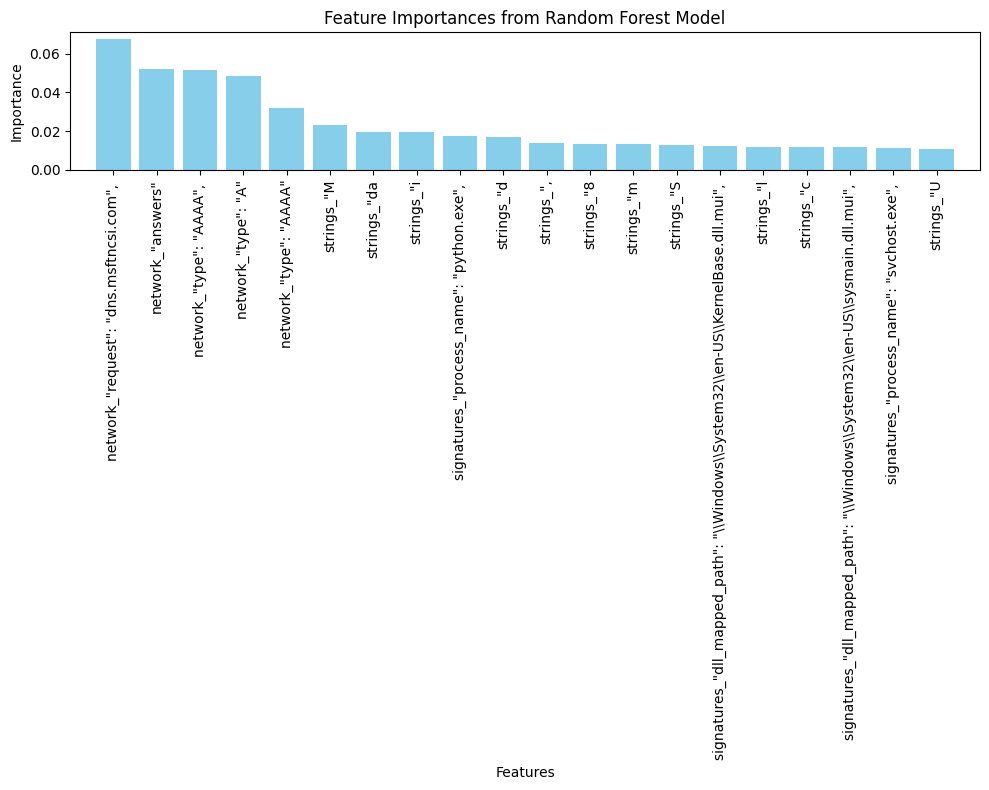

In [ ]:
# Get feature importances from the random forest model
random_forest_model = trained_models['RandomForestClassifier']
importances = random_forest_model.feature_importances_
feature_names = x.columns.tolist()
indices = np.argsort(importances)[::-1]

indices_20 = indices[:20]

# Set up the plot
plt.figure(figsize=(10, 8))
plt.title("Feature Importances from Random Forest Model")
plt.bar(range(20), importances[indices_20], color="skyblue", align="center")
plt.xticks(range(20), [feature_names[i] for i in indices_20], rotation=90)
plt.xlim([-1, 20])
plt.ylabel("Importance")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

In [ ]:
#Recursive Feature Elimination (RFE)

from sklearn.feature_selection import RFE

selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
selector = selector.fit(x_train, y_train)

selected_features = X.columns[selector.support_]
print("Selected features:", selected_features.tolist())

KeyboardInterrupt: 

In [ ]:
#boruta

from boruta import BorutaPy
import numpy as np

x_np = x_train.values
y_np = y_train

# Initialize Boruta
boruta = BorutaPy(
    estimator=RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5),
    n_estimators='auto',
    verbose=2,
    random_state=42
)

# Fit Boruta
boruta.fit(x_np, y_np)
confirmed_features = x_train.columns[boruta.support_].tolist()
print("Confirmed features:", confirmed_features)